In [1]:
import pandas as pd

df = pd.read_parquet("hf://datasets/HazemAbdelkawy/emotions/train-00000-of-00001.parquet")

c:\Users\yardz\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df.head()

,image,question,answer
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,How does the person feel in the image?,sad
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,How does the person feel in the image?,anger
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,How does the person feel in the image?,neutral
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,How does the person feel in the image?,fear
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,How does the person feel in the image?,content


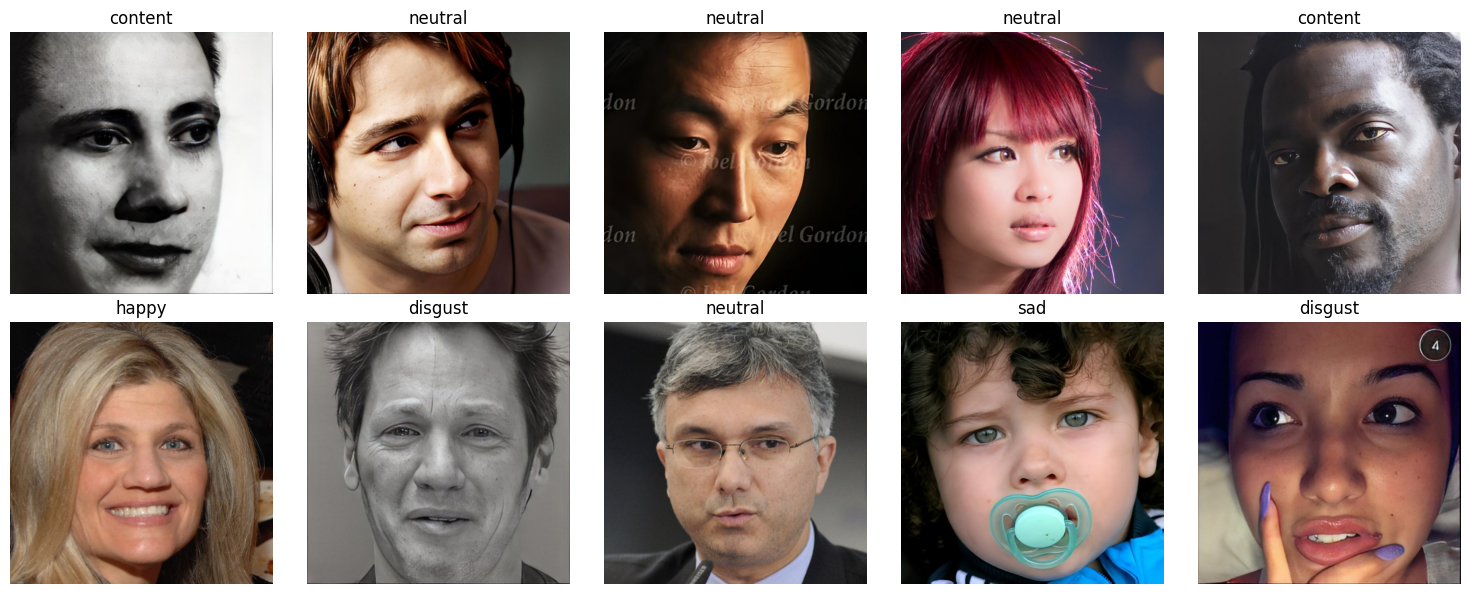

In [3]:
import numpy as np
from PIL import Image
import io

import matplotlib.pyplot as plt

# Sample 10 random rows
sample = df.sample(10, random_state=42)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for ax, (_, row) in zip(axes, sample.iterrows()):
    img_bytes = row['image']['bytes']
    img = Image.open(io.BytesIO(img_bytes))
    img_np = np.array(img)
    ax.imshow(img_np)
    ax.set_title(row['answer'])
    ax.axis('off')

plt.tight_layout()
plt.show()

In [4]:
from torch.utils.data import Dataset
from PIL import Image
import io

class BytesDictImageDataset(Dataset):
    def __init__(self, df, transform=None, label2idx=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.label2idx = label2idx or {label: idx for idx, label in enumerate(sorted(df['answer'].unique()))}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_dict = self.df.loc[idx, 'image']  # {'bytes': ...}
        img_bytes = img_dict['bytes']         # -> просто витягуємо байти
        label = self.df.loc[idx, 'answer']
        
        

        image = Image.open(io.BytesIO(img_bytes)).convert("L")  # Grayscale

        if self.transform:
            image = self.transform(image)

        return image, self.label2idx[label]


In [5]:
print(sorted(df['answer'].unique()))


['anger', 'content', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [6]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df.drop('question', axis=1), test_size=0.2, stratify=df['answer'], random_state=42)

In [7]:
from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

label2idx = {label: idx for idx, label in enumerate(sorted(df['answer'].unique()))}

train_dataset = BytesDictImageDataset(df_train, transform=transform, label2idx=label2idx)
val_dataset   = BytesDictImageDataset(df_val, transform=transform, label2idx=label2idx)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [8]:
for imgs, labels in train_loader:
    print("Train batch:", imgs.shape, labels.shape)
    break

for imgs, labels in val_loader:
    print("Val batch:", imgs.shape, labels.shape)
    break


Train batch: torch.Size([64, 1, 48, 48]) torch.Size([64])
Val batch: torch.Size([64, 1, 48, 48]) torch.Size([64])


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EmotionCNN(nn.Module):
    def __init__(self, num_classes=8):
        super(EmotionCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # (B, 1, 48, 48) -> (B, 32, 48, 48)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)                          # -> (B, 32, 24, 24)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # -> (B, 64, 24, 24)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)                          # -> (B, 64, 12, 12)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # -> (B, 128, 12, 12)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)                           # -> (B, 128, 6, 6)

        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 6 * 6, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        
        x = x.view(x.size(0), -1)  # flatten
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using device:", device)

Using device: cuda


In [11]:
print("Unique labels:", labels.unique())  # побачиш всі унікальні мітки


Unique labels: tensor([0, 1, 2, 3, 4, 5, 6, 7])


In [12]:
model = EmotionCNN(num_classes=8).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [13]:

print(labels)



tensor([5, 0, 7, 2, 0, 6, 6, 0, 6, 2, 7, 6, 6, 1, 1, 3, 0, 3, 2, 1, 6, 5, 1, 1,
        6, 3, 0, 1, 4, 0, 7, 2, 6, 0, 6, 7, 5, 3, 3, 2, 6, 4, 5, 0, 6, 0, 5, 5,
        4, 3, 7, 6, 6, 3, 5, 7, 1, 1, 4, 1, 6, 7, 6, 0])


In [14]:
for epoch in range(10):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}")


Epoch 1, Loss: 252.1144
Epoch 2, Loss: 239.0213
Epoch 3, Loss: 229.4551
Epoch 4, Loss: 224.0148
Epoch 5, Loss: 216.7839
Epoch 6, Loss: 212.1206
Epoch 7, Loss: 205.6867
Epoch 8, Loss: 202.1278
Epoch 9, Loss: 198.6465
Epoch 10, Loss: 196.0305


In [15]:
model.eval()
total = 0
correct = 0

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Validation accuracy: {accuracy:.4f}')


Validation accuracy: 0.4213


In [16]:
torch.save(model.state_dict(), 'emotion_cnn.pth')
model = EmotionCNN(num_classes=8).to(device)
model.load_state_dict(torch.load('emotion_cnn.pth'))
model.eval()  # переключаємо модель в режим оцінки


EmotionCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=4608, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=8, bias=True)
)

In [21]:
import cv2
import torch
from torchvision import transforms
from PIL import Image


# Каскад для детекції облич
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# Трансформації як при тренуванні
transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor()
])

# Мапа індексу в емоцію
idx2label = ['anger', 'content', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

cap = cv2.VideoCapture(1)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        face_img = gray[y:y+h, x:x+w]
        pil_img = Image.fromarray(face_img)
        input_tensor = transform(pil_img).unsqueeze(0)

        with torch.no_grad():
            outputs = model(input_tensor)
            _, predicted = torch.max(outputs, 1)
            label = idx2label[predicted.item()]

        # Малюємо прямокутник + назву емоції
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

    cv2.imshow('Emotion Detection', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
